In [1]:
from google.colab import files

# Upload your train.parquet file
print("📤 Please select your train.parquet file...")
uploaded = files.upload()

print("✅ File uploaded successfully!")

📤 Please select your train.parquet file...


Saving train.parquet to train.parquet
✅ File uploaded successfully!


In [2]:
"""
Hack4Health AI for Alzheimer's Challenge
========================================
Team: Mind Mavericks
Date: December 2025

This notebook implements a deep learning pipeline for classifying
Alzheimer's Disease stages from MRI scans using transfer learning
with ResNet18 architecture.

Dataset: Alzheimer MRI Disease Classification Dataset
Classes: Glioma, Meningioma, Healthy, Pituitary
"""

import random
import os
import numpy as np
import torch

# ============================================
# REPRODUCIBILITY SETUP (REQUIRED!)
# ============================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(SEED)

print("✅ Reproducibility seeds set!")
print(f"🔥 GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU Device: {torch.cuda.get_device_name(0)}")

✅ Reproducibility seeds set!
🔥 GPU Available: True
   GPU Device: Tesla T4


In [3]:
# ============================================
# IMPORTS
# ============================================

# Data manipulation
import pandas as pd
import numpy as np

# Image processing
import io
from PIL import Image
import cv2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms

# Metrics and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report,
                             precision_recall_fscore_support)

# Progress bars
from tqdm import tqdm

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [4]:
# ============================================
# CONFIGURATION
# ============================================

# Class names - MUST match your dataset labels
CLASS_NAMES = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']
NUM_CLASSES = len(CLASS_NAMES)

# Hyperparameters
CONFIG = {
    'batch_size': 32,
    'image_size': 224,
    'learning_rate': 1e-4,
    'epochs': 15,
    'test_size': 0.2,
    'seed': SEED,
    'num_workers': 2,
}

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")
print(f"📊 Configuration:")
for key, value in CONFIG.items():
    print(f"   {key}: {value}")

✅ Using device: cuda
📊 Configuration:
   batch_size: 32
   image_size: 224
   learning_rate: 0.0001
   epochs: 15
   test_size: 0.2
   seed: 42
   num_workers: 2


In [5]:
# ============================================
# DATA LOADING
# ============================================

# Load the parquet file
df = pd.read_parquet('train.parquet')

print(f"✅ Dataset loaded successfully!")
print(f"📊 Dataset shape: {df.shape}")
print(f"📋 Columns: {df.columns.tolist()}")
print(f"\n🔍 First few rows:")
df.head()

✅ Dataset loaded successfully!
📊 Dataset shape: (5120, 2)
📋 Columns: ['image', 'label']

🔍 First few rows:


,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


In [6]:
# ============================================
# IMAGE PREPROCESSING UTILITIES
# ============================================

def preprocess_image(byte_data):
    """
    Convert byte data to preprocessed image array

    Args:
        byte_data: Image bytes from dataset

    Returns:
        numpy array: Preprocessed image (224x224x3)
    """
    # Convert bytes to PIL Image
    img = Image.open(io.BytesIO(byte_data))

    # Convert to RGB (3 channels for transfer learning)
    img = img.convert("RGB")

    # Resize to standard size
    img = img.resize((CONFIG['image_size'], CONFIG['image_size']))

    # Convert to numpy array and normalize
    img_array = np.array(img) / 255.0

    return img_array

def get_mean_intensity(byte_data):
    """Calculate mean pixel intensity of grayscale image"""
    img = Image.open(io.BytesIO(byte_data)).convert("L")
    return np.mean(np.array(img))

print("✅ Preprocessing functions defined!")

✅ Preprocessing functions defined!


📊 EXPLORATORY DATA ANALYSIS


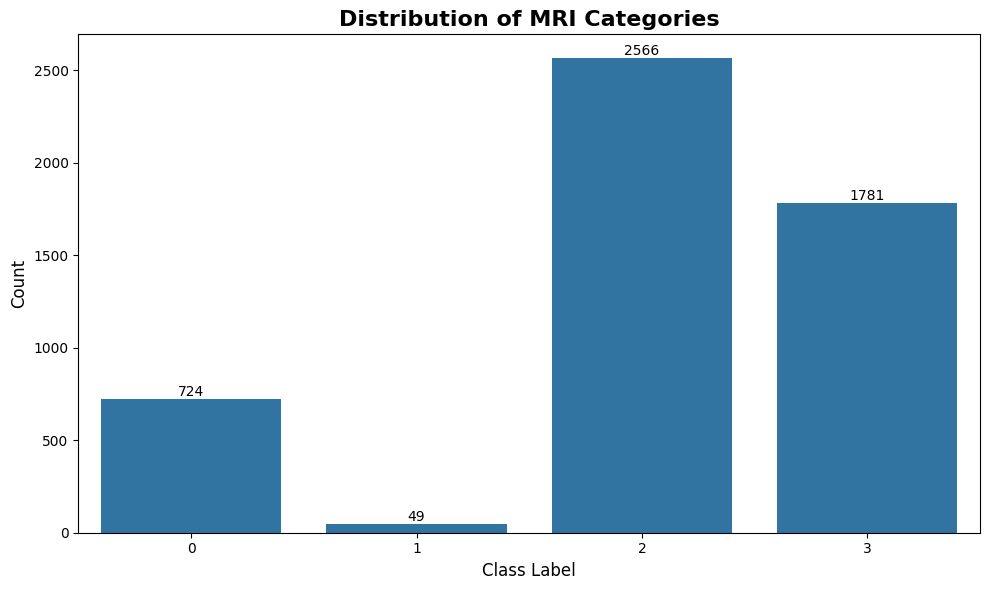


📈 Class Distribution:
   Mild Demented (Label 0): 724 samples (14.14%)
   Moderate Demented (Label 1): 49 samples (0.96%)
   Non Demented (Label 2): 2566 samples (50.12%)
   Very Mild Demented (Label 3): 1781 samples (34.79%)

📊 Total samples: 5120


In [7]:
# ============================================
# EXPLORATORY DATA ANALYSIS (EDA)
# ============================================

print("📊 EXPLORATORY DATA ANALYSIS")
print("=" * 50)

# 1. Class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title("Distribution of MRI Categories", fontsize=16, fontweight='bold')
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Add count labels on bars
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()
plt.show()

# Print class distribution
print("\n📈 Class Distribution:")
class_counts = df['label'].value_counts().sort_index()
for idx, count in class_counts.items():
    class_name = CLASS_NAMES[idx] if idx < len(CLASS_NAMES) else f"Class {idx}"
    percentage = (count / len(df)) * 100
    print(f"   {class_name} (Label {idx}): {count} samples ({percentage:.2f}%)")

print(f"\n📊 Total samples: {len(df)}")


🔍 Analyzing mean brightness by class...


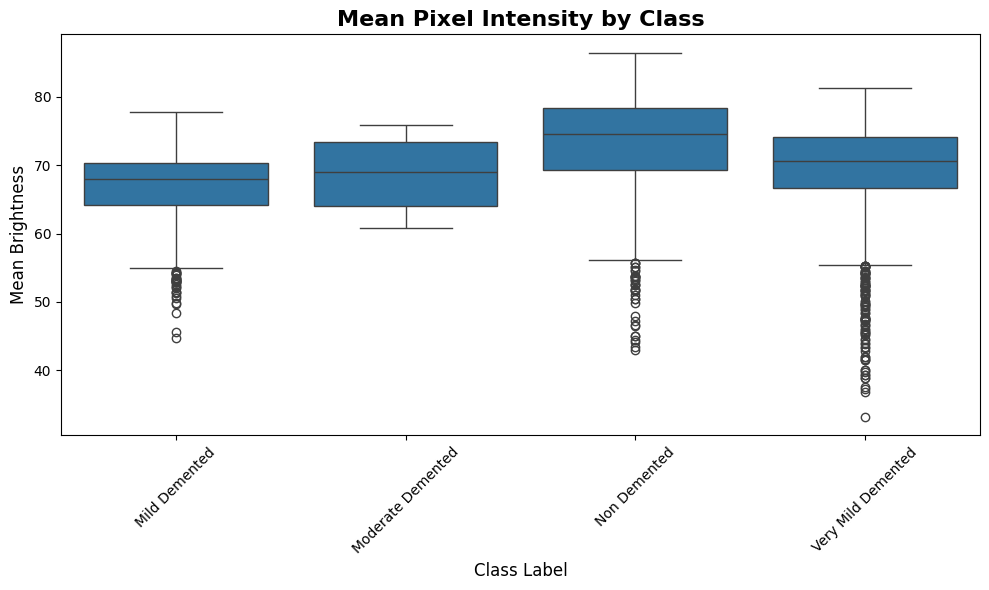

✅ Brightness analysis complete!


In [8]:
# 2. Mean brightness analysis by class
print("\n🔍 Analyzing mean brightness by class...")

df['mean_brightness'] = df['image'].apply(lambda x: get_mean_intensity(x['bytes']))

plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='mean_brightness', data=df)
plt.title("Mean Pixel Intensity by Class", fontsize=16, fontweight='bold')
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Mean Brightness", fontsize=12)
plt.xticks(range(NUM_CLASSES), CLASS_NAMES, rotation=45)
plt.tight_layout()
plt.show()

print("✅ Brightness analysis complete!")


🖼️ Visualizing sample images from each class...


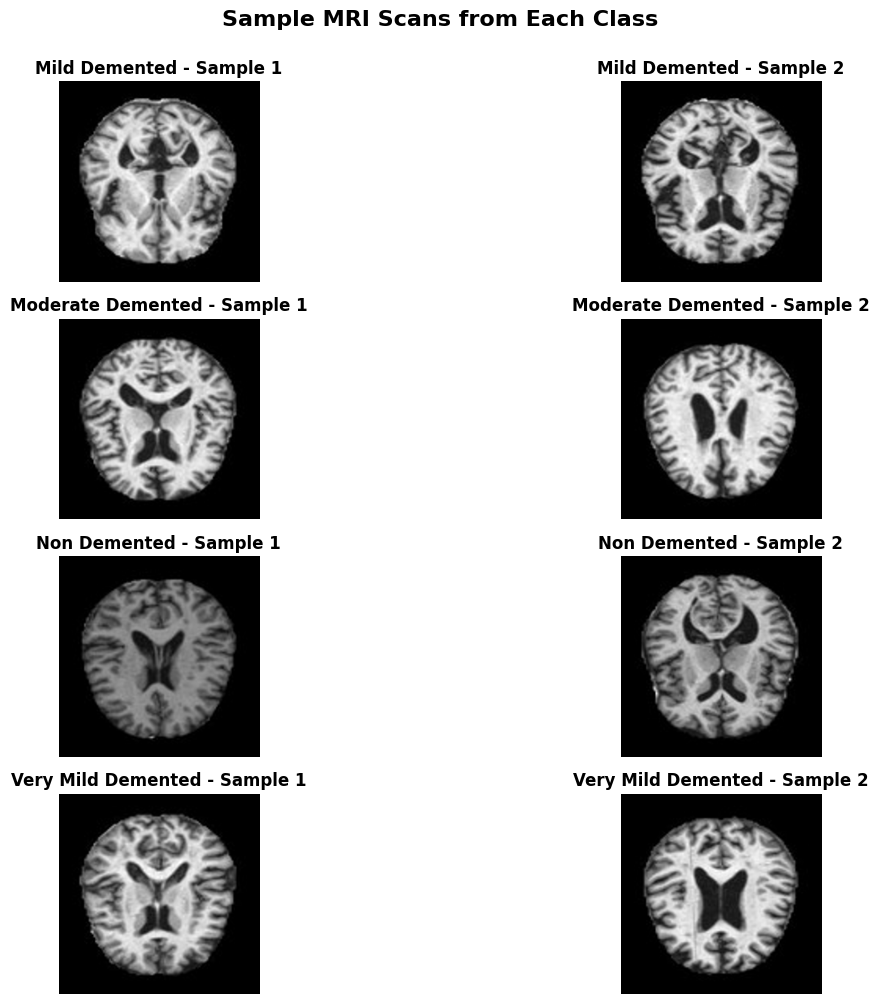

✅ Sample visualization complete!


In [9]:
# 3. Visualize sample images from each class
print("\n🖼️ Visualizing sample images from each class...")

plt.figure(figsize=(15, 10))

# Show 2 samples from each class
for class_idx in range(NUM_CLASSES):
    class_samples = df[df['label'] == class_idx].head(2)

    for i, (idx, row) in enumerate(class_samples.iterrows()):
        plt.subplot(NUM_CLASSES, 2, class_idx * 2 + i + 1)
        img_data = preprocess_image(row['image']['bytes'])
        plt.imshow(img_data)
        plt.title(f"{CLASS_NAMES[class_idx]} - Sample {i+1}", fontweight='bold')
        plt.axis('off')

plt.suptitle("Sample MRI Scans from Each Class", fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✅ Sample visualization complete!")

In [10]:
# ============================================
# TRAIN-VALIDATION SPLIT
# ============================================

print("🔀 Splitting dataset into train and validation sets...")

train_df, val_df = train_test_split(
    df,
    test_size=CONFIG['test_size'],
    stratify=df['label'],  # Maintain class distribution
    random_state=CONFIG['seed']
)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"✅ Split complete!")
print(f"   Training samples: {len(train_df)}")
print(f"   Validation samples: {len(val_df)}")

# Verify stratification
print("\n📊 Class distribution in train set:")
for idx in range(NUM_CLASSES):
    count = (train_df['label'] == idx).sum()
    percentage = (count / len(train_df)) * 100
    print(f"   {CLASS_NAMES[idx]}: {count} ({percentage:.2f}%)")

print("\n📊 Class distribution in validation set:")
for idx in range(NUM_CLASSES):
    count = (val_df['label'] == idx).sum()
    percentage = (count / len(val_df)) * 100
    print(f"   {CLASS_NAMES[idx]}: {count} ({percentage:.2f}%)")

🔀 Splitting dataset into train and validation sets...
✅ Split complete!
   Training samples: 4096
   Validation samples: 1024

📊 Class distribution in train set:
   Mild Demented: 579 (14.14%)
   Moderate Demented: 39 (0.95%)
   Non Demented: 2053 (50.12%)
   Very Mild Demented: 1425 (34.79%)

📊 Class distribution in validation set:
   Mild Demented: 145 (14.16%)
   Moderate Demented: 10 (0.98%)
   Non Demented: 513 (50.10%)
   Very Mild Demented: 356 (34.77%)


In [11]:
# ============================================
# CUSTOM DATASET CLASS
# ============================================

class MRIDataset(Dataset):
    """
    Custom PyTorch Dataset for MRI images

    Args:
        dataframe: pandas DataFrame containing image bytes and labels
        transform: torchvision transforms to apply to images
    """

    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image bytes and decode
        img_bytes = self.df.iloc[idx]['image']['bytes']
        image = Image.open(io.BytesIO(img_bytes)).convert('RGB')

        # Get label
        label = self.df.iloc[idx]['label']

        # Apply transforms if provided
        if self.transform:
            image = self.transform(image)

        return image, label

print("✅ Custom Dataset class defined!")

✅ Custom Dataset class defined!


In [12]:
# ============================================
# DATA AUGMENTATION & TRANSFORMS
# ============================================

# ImageNet normalization (for transfer learning)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transforms with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Validation transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("✅ Data transforms defined!")
print("\n📋 Training augmentations:")
print("   - Random horizontal flip")
print("   - Random rotation (±15°)")
print("   - Color jitter (brightness & contrast)")
print("   - ImageNet normalization")

✅ Data transforms defined!

📋 Training augmentations:
   - Random horizontal flip
   - Random rotation (±15°)
   - Color jitter (brightness & contrast)
   - ImageNet normalization


In [13]:
# ============================================
# CREATE DATALOADERS
# ============================================

print("🔄 Creating DataLoaders...")

# Create dataset instances
train_dataset = MRIDataset(train_df, transform=train_transform)
val_dataset = MRIDataset(val_df, transform=val_transform)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"✅ DataLoaders created!")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Batch size: {CONFIG['batch_size']}")

# Test loading a batch
test_images, test_labels = next(iter(train_loader))
print(f"\n🔍 Sample batch shape:")
print(f"   Images: {test_images.shape}")
print(f"   Labels: {test_labels.shape}")

🔄 Creating DataLoaders...
✅ DataLoaders created!
   Training batches: 128
   Validation batches: 32
   Batch size: 32

🔍 Sample batch shape:
   Images: torch.Size([32, 3, 224, 224])
   Labels: torch.Size([32])


In [14]:
# ============================================
# MODEL ARCHITECTURE
# ============================================

print("🏗️ Building model with transfer learning...")

# Load pre-trained ResNet18
model = models.resnet18(weights='IMAGENET1K_V1')

# Freeze early layers (optional - uncomment to freeze)
# for param in model.parameters():
#     param.requires_grad = False

# Replace final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# Move model to device
model = model.to(device)

print("✅ Model built successfully!")
print(f"   Architecture: ResNet18")
print(f"   Pre-trained: Yes (ImageNet)")
print(f"   Output classes: {NUM_CLASSES}")
print(f"   Final layer: Linear({num_ftrs} → {NUM_CLASSES})")

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Model Parameters:")
print(f"   Total: {total_params:,}")
print(f"   Trainable: {trainable_params:,}")

🏗️ Building model with transfer learning...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 48.7MB/s]


✅ Model built successfully!
   Architecture: ResNet18
   Pre-trained: Yes (ImageNet)
   Output classes: 4
   Final layer: Linear(512 → 4)

📊 Model Parameters:
   Total: 11,178,564
   Trainable: 11,178,564


In [15]:
# ============================================
# LOSS FUNCTION & OPTIMIZER
# ============================================

print("⚙️ Setting up loss function and optimizer...")

# Calculate class weights to handle imbalance
class_counts = train_df['label'].value_counts().sort_index().values
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * NUM_CLASSES
class_weights = torch.FloatTensor(class_weights).to(device)

print(f"\n📊 Class weights for balanced loss:")
for idx, weight in enumerate(class_weights):
    print(f"   {CLASS_NAMES[idx]}: {weight:.4f}")

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

# Learning rate scheduler (removed 'verbose' parameter)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=3,
    factor=0.5
)

print(f"\n✅ Training setup complete!")
print(f"   Loss function: CrossEntropyLoss (weighted)")
print(f"   Optimizer: Adam (lr={CONFIG['learning_rate']})")
print(f"   Scheduler: ReduceLROnPlateau (patience=3, factor=0.5)")

⚙️ Setting up loss function and optimizer...

📊 Class weights for balanced loss:
   Mild Demented: 0.2419
   Moderate Demented: 3.5916
   Non Demented: 0.0682
   Very Mild Demented: 0.0983

✅ Training setup complete!
   Loss function: CrossEntropyLoss (weighted)
   Optimizer: Adam (lr=0.0001)
   Scheduler: ReduceLROnPlateau (patience=3, factor=0.5)


In [16]:
# ============================================
# EARLY STOPPING UTILITY
# ============================================

class EarlyStopping:
    """Early stopping to prevent overfitting"""

    def __init__(self, patience=5, min_delta=0.001, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"   ⚠️ EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("   🛑 Early stopping triggered!")
        else:
            if self.verbose:
                print(f"   ✅ Validation loss improved: {self.best_loss:.4f} → {val_loss:.4f}")
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0

print("✅ Early stopping class defined!")

✅ Early stopping class defined!


In [17]:
# ============================================
# TRAINING FUNCTION
# ============================================

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=15):
    """
    Train the model with validation

    Returns:
        model: Trained model
        history: Training history dictionary
    """

    model.to(device)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=5, verbose=True)

    # Track metrics
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'lr': []
    }

    print("\n" + "="*70)
    print("🚀 STARTING TRAINING")
    print("="*70)

    for epoch in range(epochs):
        print(f"\n{'='*70}")
        print(f"📅 Epoch {epoch+1}/{epochs}")
        print(f"{'='*70}")

        # ========== TRAINING PHASE ==========
        model.train()
        running_loss = 0.0
        running_corrects = 0

        train_pbar = tqdm(train_loader, desc="🔄 Training", leave=False)
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Update progress bar
            train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double() / len(train_loader.dataset)

        # ========== VALIDATION PHASE ==========
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        val_pbar = tqdm(val_loader, desc="✅ Validation", leave=False)
        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

                val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        # Learning rate scheduling
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        # Store metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc.item())
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())
        history['lr'].append(current_lr)

        # Print epoch results
        print(f"\n📊 Epoch {epoch+1} Results:")
        print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"   Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
        print(f"   Learning Rate: {current_lr:.6f}")

        # Early stopping check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("\n🛑 Training stopped early!")
            model.load_state_dict(early_stopping.best_model)
            break

    print("\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)

    return model, history

print("✅ Training function defined!")

✅ Training function defined!


In [18]:
# ============================================
# TRAIN THE MODEL
# ============================================

# Start training
trained_model, history = train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    train_loader,
    val_loader,
    epochs=CONFIG['epochs']
)

print("\n🎉 Model training finished!")


🚀 STARTING TRAINING

📅 Epoch 1/15



📊 Epoch 1 Results:
   Train Loss: 1.1448 | Train Acc: 0.5103
   Val Loss:   0.8524 | Val Acc:   0.6074
   Learning Rate: 0.000100

📅 Epoch 2/15



📊 Epoch 2 Results:
   Train Loss: 0.7632 | Train Acc: 0.6304
   Val Loss:   0.7366 | Val Acc:   0.6670
   Learning Rate: 0.000100
   ✅ Validation loss improved: 0.8524 → 0.7366

📅 Epoch 3/15



📊 Epoch 3 Results:
   Train Loss: 0.6530 | Train Acc: 0.6792
   Val Loss:   0.7888 | Val Acc:   0.5469
   Learning Rate: 0.000100
   ⚠️ EarlyStopping counter: 1/5

📅 Epoch 4/15



📊 Epoch 4 Results:
   Train Loss: 0.5177 | Train Acc: 0.7493
   Val Loss:   0.4814 | Val Acc:   0.7539
   Learning Rate: 0.000100
   ✅ Validation loss improved: 0.7366 → 0.4814

📅 Epoch 5/15



📊 Epoch 5 Results:
   Train Loss: 0.4381 | Train Acc: 0.7822
   Val Loss:   0.4698 | Val Acc:   0.7598
   Learning Rate: 0.000100
   ✅ Validation loss improved: 0.4814 → 0.4698

📅 Epoch 6/15



📊 Epoch 6 Results:
   Train Loss: 0.3971 | Train Acc: 0.8201
   Val Loss:   0.6729 | Val Acc:   0.7861
   Learning Rate: 0.000100
   ⚠️ EarlyStopping counter: 1/5

📅 Epoch 7/15



📊 Epoch 7 Results:
   Train Loss: 0.3612 | Train Acc: 0.8354
   Val Loss:   0.3258 | Val Acc:   0.8623
   Learning Rate: 0.000100
   ✅ Validation loss improved: 0.4698 → 0.3258

📅 Epoch 8/15



📊 Epoch 8 Results:
   Train Loss: 0.2553 | Train Acc: 0.8818
   Val Loss:   0.3363 | Val Acc:   0.8320
   Learning Rate: 0.000100
   ⚠️ EarlyStopping counter: 1/5

📅 Epoch 9/15



📊 Epoch 9 Results:
   Train Loss: 0.2000 | Train Acc: 0.9075
   Val Loss:   0.4223 | Val Acc:   0.7832
   Learning Rate: 0.000100
   ⚠️ EarlyStopping counter: 2/5

📅 Epoch 10/15



📊 Epoch 10 Results:
   Train Loss: 0.1700 | Train Acc: 0.9221
   Val Loss:   0.3243 | Val Acc:   0.9014
   Learning Rate: 0.000100
   ✅ Validation loss improved: 0.3258 → 0.3243

📅 Epoch 11/15



📊 Epoch 11 Results:
   Train Loss: 0.1483 | Train Acc: 0.9324
   Val Loss:   0.1959 | Val Acc:   0.9268
   Learning Rate: 0.000100
   ✅ Validation loss improved: 0.3243 → 0.1959

📅 Epoch 12/15



📊 Epoch 12 Results:
   Train Loss: 0.1097 | Train Acc: 0.9480
   Val Loss:   0.3175 | Val Acc:   0.8369
   Learning Rate: 0.000100
   ⚠️ EarlyStopping counter: 1/5

📅 Epoch 13/15



📊 Epoch 13 Results:
   Train Loss: 0.1151 | Train Acc: 0.9468
   Val Loss:   0.1935 | Val Acc:   0.9307
   Learning Rate: 0.000100
   ✅ Validation loss improved: 0.1959 → 0.1935

📅 Epoch 14/15



📊 Epoch 14 Results:
   Train Loss: 0.0907 | Train Acc: 0.9619
   Val Loss:   0.2525 | Val Acc:   0.8633
   Learning Rate: 0.000100
   ⚠️ EarlyStopping counter: 1/5

📅 Epoch 15/15



📊 Epoch 15 Results:
   Train Loss: 0.1070 | Train Acc: 0.9512
   Val Loss:   0.2894 | Val Acc:   0.8955
   Learning Rate: 0.000100
   ⚠️ EarlyStopping counter: 2/5

✅ TRAINING COMPLETE!

🎉 Model training finished!


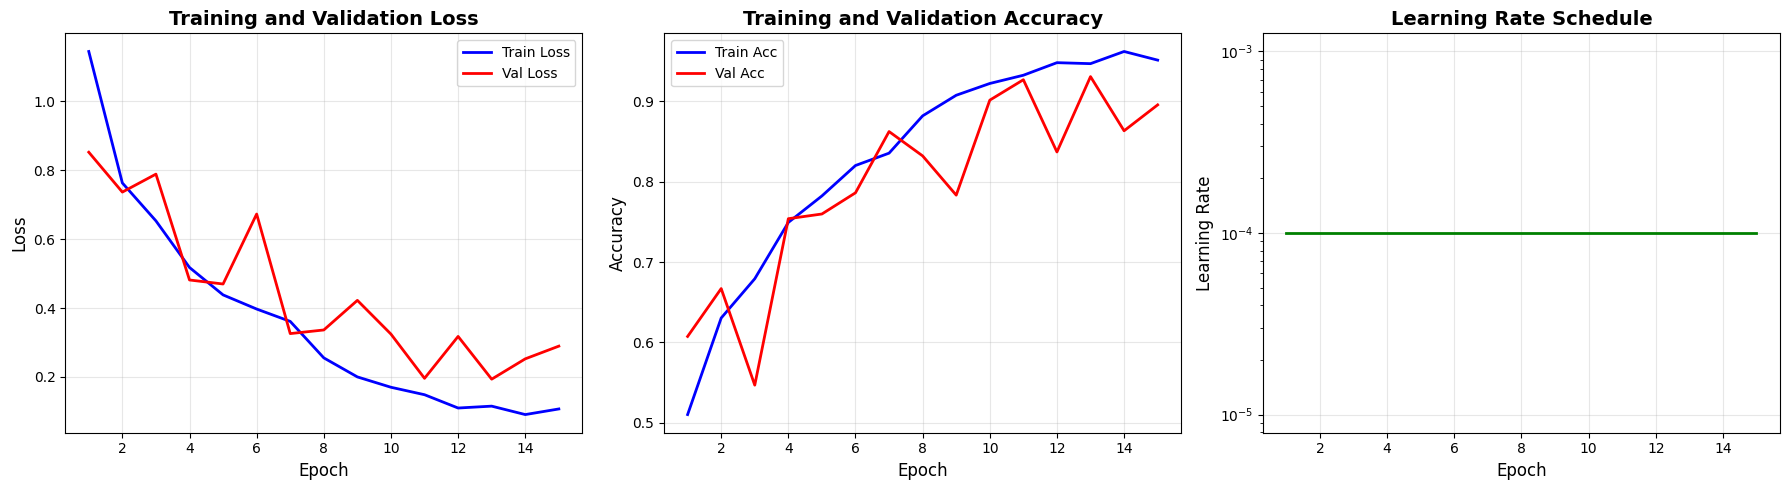


📊 Final Training Metrics:
   Best Train Acc: 0.9619
   Best Val Acc: 0.9307
   Final Train Loss: 0.1070
   Final Val Loss: 0.2894


In [19]:
# ============================================
# VISUALIZE TRAINING HISTORY
# ============================================

def plot_training_history(history):
    """Plot training and validation metrics"""

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    epochs_range = range(1, len(history['train_loss']) + 1)

    # Loss plot
    axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[1].plot(epochs_range, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    axes[1].plot(epochs_range, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Learning rate plot
    axes[2].plot(epochs_range, history['lr'], 'g-', linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('Learning Rate', fontsize=12)
    axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_yscale('log')

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print("\n📊 Final Training Metrics:")
    print(f"   Best Train Acc: {max(history['train_acc']):.4f}")
    print(f"   Best Val Acc: {max(history['val_acc']):.4f}")
    print(f"   Final Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"   Final Val Loss: {history['val_loss'][-1]:.4f}")

# Plot the history
plot_training_history(history)

🔍 Generating predictions for confusion matrix...


Predicting: 100%|██████████| 32/32 [00:02<00:00, 13.53it/s]


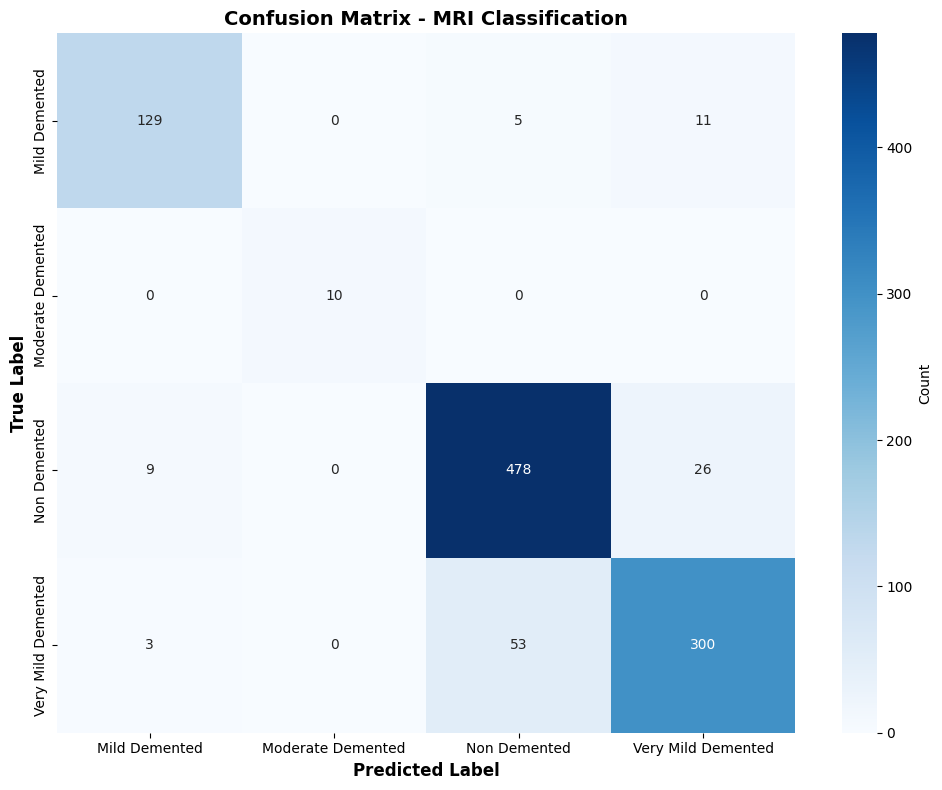


📋 CLASSIFICATION REPORT
                    precision    recall  f1-score   support

     Mild Demented     0.9149    0.8897    0.9021       145
 Moderate Demented     1.0000    1.0000    1.0000        10
      Non Demented     0.8918    0.9318    0.9113       513
Very Mild Demented     0.8902    0.8427    0.8658       356

          accuracy                         0.8955      1024
         macro avg     0.9242    0.9160    0.9198      1024
      weighted avg     0.8956    0.8955    0.8951      1024



In [20]:
# ============================================
# CONFUSION MATRIX
# ============================================

def plot_confusion_matrix(model, val_loader, device, class_names):
    """Generate and plot confusion matrix"""

    model.eval()
    y_true = []
    y_pred = []

    print("🔍 Generating predictions for confusion matrix...")

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Predicting"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.title('Confusion Matrix - MRI Classification', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Classification report
    print("\n" + "="*70)
    print("📋 CLASSIFICATION REPORT")
    print("="*70)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    return y_true, y_pred

# Generate confusion matrix
y_true, y_pred = plot_confusion_matrix(trained_model, val_loader, device, CLASS_NAMES)

🔍 Generating predictions for confusion matrix...


Predicting: 100%|██████████| 32/32 [00:02<00:00, 11.24it/s]


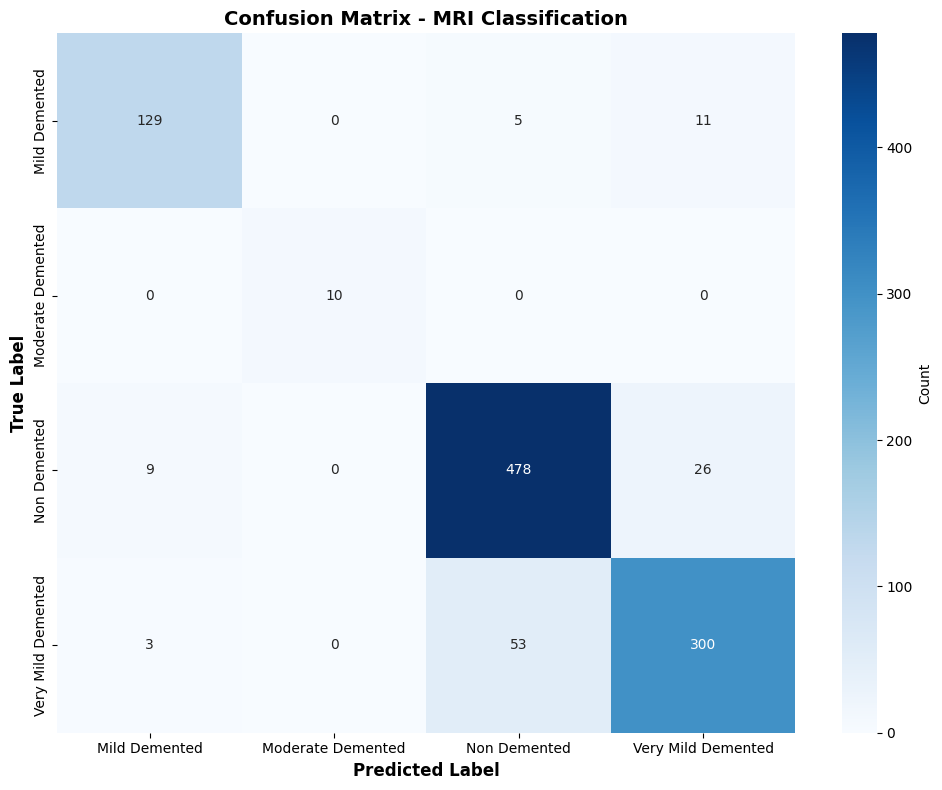


📋 CLASSIFICATION REPORT
                    precision    recall  f1-score   support

     Mild Demented     0.9149    0.8897    0.9021       145
 Moderate Demented     1.0000    1.0000    1.0000        10
      Non Demented     0.8918    0.9318    0.9113       513
Very Mild Demented     0.8902    0.8427    0.8658       356

          accuracy                         0.8955      1024
         macro avg     0.9242    0.9160    0.9198      1024
      weighted avg     0.8956    0.8955    0.8951      1024



In [21]:
# ============================================
# CONFUSION MATRIX
# ============================================

def plot_confusion_matrix(model, val_loader, device, class_names):
    """Generate and plot confusion matrix"""

    model.eval()
    y_true = []
    y_pred = []

    print("🔍 Generating predictions for confusion matrix...")

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Predicting"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.title('Confusion Matrix - MRI Classification', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Classification report
    print("\n" + "="*70)
    print("📋 CLASSIFICATION REPORT")
    print("="*70)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    return y_true, y_pred

# Generate confusion matrix
y_true, y_pred = plot_confusion_matrix(trained_model, val_loader, device, CLASS_NAMES)

In [23]:
# ============================================
# PER-CLASS PERFORMANCE METRICS
# ============================================

def evaluate_per_class(y_true, y_pred, class_names):
    """Detailed per-class performance metrics"""

    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None
    )

    # Create results dataframe
    results_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })

    print("\n" + "="*70)
    print("📊 PER-CLASS PERFORMANCE METRICS")
    print("="*70)
    print(results_df.to_string(index=False))
    print("="*70)

    # Overall accuracy
    overall_acc = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
    print(f"\n🎯 Overall Accuracy: {overall_acc:.4f} ({overall_acc*100:.2f}%)")

    # Macro and weighted averages
    macro_f1 = f1.mean()
    weighted_f1 = np.average(f1, weights=support)
    print(f"📈 Macro F1-Score: {macro_f1:.4f}")
    print(f"📈 Weighted F1-Score: {weighted_f1:.4f}")

    return results_df

# Evaluate per-class performance
results_df = evaluate_per_class(y_true, y_pred, CLASS_NAMES)


📊 PER-CLASS PERFORMANCE METRICS
             Class  Precision   Recall  F1-Score  Support
     Mild Demented   0.914894 0.889655  0.902098      145
 Moderate Demented   1.000000 1.000000  1.000000       10
      Non Demented   0.891791 0.931774  0.911344      513
Very Mild Demented   0.890208 0.842697  0.865801      356

🎯 Overall Accuracy: 0.8955 (89.55%)
📈 Macro F1-Score: 0.9198
📈 Weighted F1-Score: 0.8951


🔍 Analyzing misclassifications...


Finding errors: 100%|██████████| 32/32 [00:02<00:00, 13.50it/s]



❌ Total misclassifications: 107 / 1024
   Error rate: 10.45%


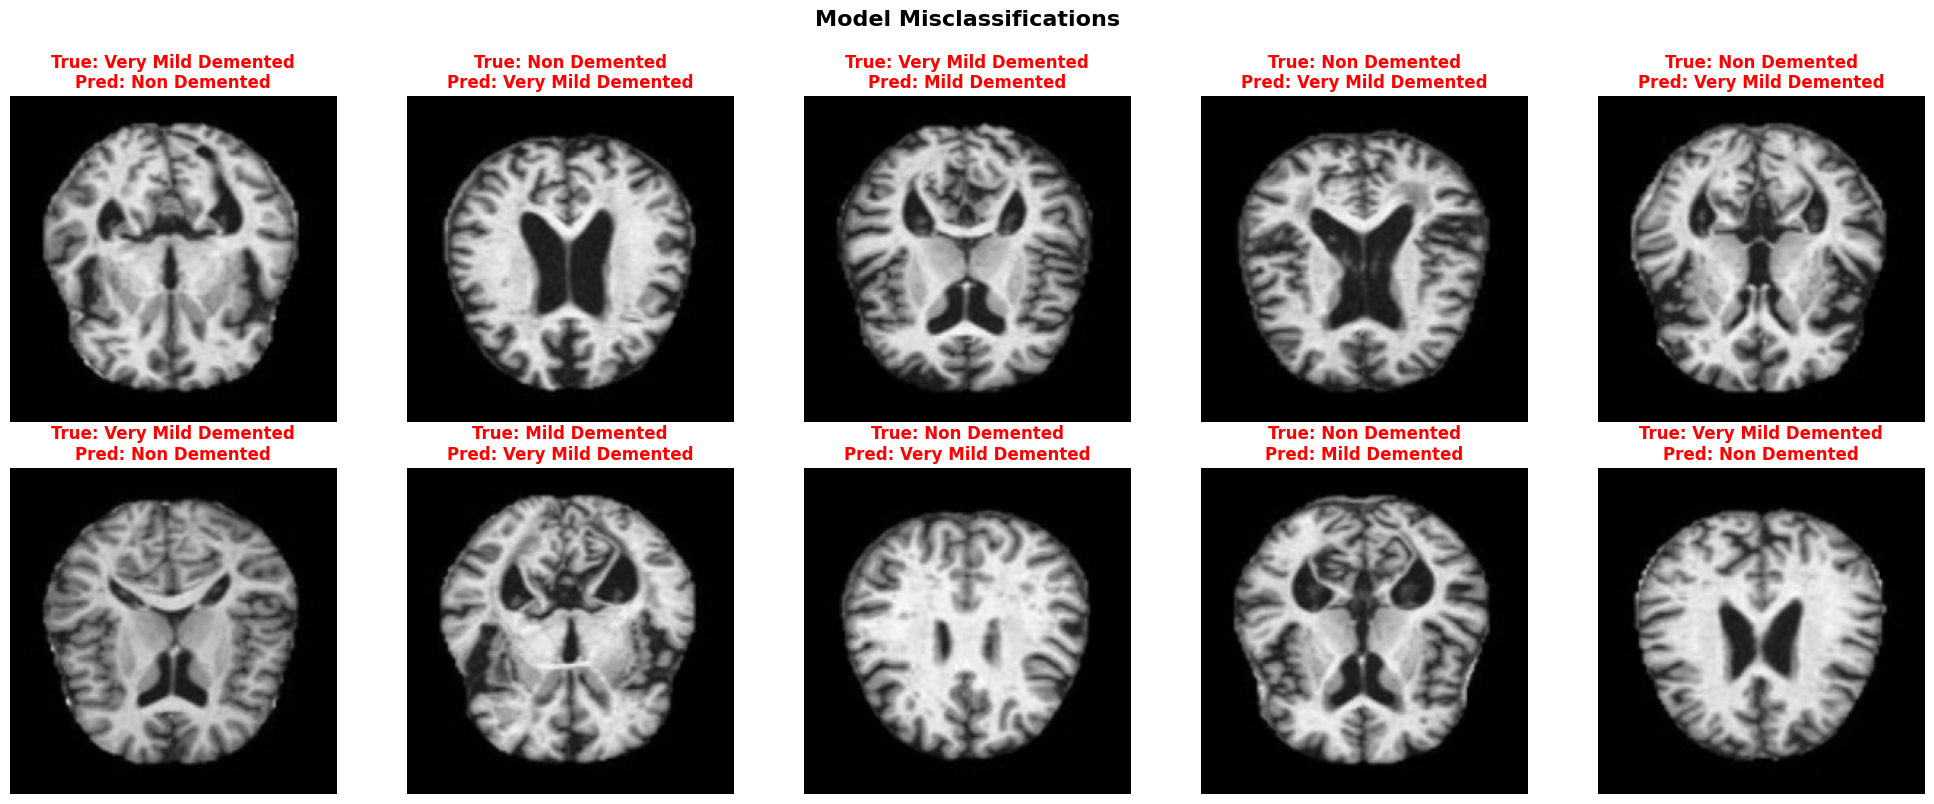


📊 Errors by True Class:
   Mild Demented: 16
   Non Demented: 35
   Very Mild Demented: 56

📊 Errors by Predicted Class:
   Mild Demented: 12
   Non Demented: 58
   Very Mild Demented: 37


In [24]:
# ============================================
# ERROR ANALYSIS
# ============================================

def analyze_errors(model, val_loader, device, class_names):
    """Analyze and visualize model errors"""

    model.eval()
    errors = []

    print("🔍 Analyzing misclassifications...")

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Finding errors"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Find misclassifications
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    errors.append({
                        'true': labels[i].item(),
                        'pred': preds[i].item(),
                        'image': inputs[i].cpu()
                    })

    print(f"\n❌ Total misclassifications: {len(errors)} / {len(val_loader.dataset)}")
    print(f"   Error rate: {len(errors)/len(val_loader.dataset)*100:.2f}%")

    if len(errors) == 0:
        print("🎉 Perfect predictions! No errors to visualize.")
        return errors

    # Visualize some errors
    num_show = min(10, len(errors))
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for idx in range(num_show):
        error = errors[idx]

        # Denormalize image for display
        img = error['image'].numpy().transpose(1, 2, 0)
        img = img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
        img = np.clip(img, 0, 1)

        axes[idx].imshow(img)
        axes[idx].set_title(
            f"True: {class_names[error['true']]}\nPred: {class_names[error['pred']]}",
            color='red',
            fontweight='bold'
        )
        axes[idx].axis('off')

    # Hide unused subplots
    for idx in range(num_show, 10):
        axes[idx].axis('off')

    plt.suptitle('Model Misclassifications', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

    # Error distribution by class
    error_by_true = {}
    error_by_pred = {}
    for error in errors:
        true_class = class_names[error['true']]
        pred_class = class_names[error['pred']]
        error_by_true[true_class] = error_by_true.get(true_class, 0) + 1
        error_by_pred[pred_class] = error_by_pred.get(pred_class, 0) + 1

    print("\n📊 Errors by True Class:")
    for class_name, count in sorted(error_by_true.items()):
        print(f"   {class_name}: {count}")

    print("\n📊 Errors by Predicted Class:")
    for class_name, count in sorted(error_by_pred.items()):
        print(f"   {class_name}: {count}")

    return errors

# Run error analysis
errors = analyze_errors(trained_model, val_loader, device, CLASS_NAMES)

In [25]:
# ============================================
# INSTALL GRAD-CAM LIBRARY
# ============================================

!pip install grad-cam -q

print("✅ Grad-CAM library installed!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✅ Grad-CAM library installed!


In [26]:
# ============================================
# GRAD-CAM EXPLAINABILITY
# ============================================

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

class GradCAMVisualizer:
    """Grad-CAM visualization for model explainability"""

    def __init__(self, model, target_layer):
        self.model = model
        self.cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())

    def visualize(self, input_tensor, true_label, pred_label, class_names, save_path=None):
        """
        Visualize Grad-CAM for a single image

        Args:
            input_tensor: Preprocessed input tensor
            true_label: Ground truth label
            pred_label: Predicted label
            class_names: List of class names
            save_path: Optional path to save figure
        """
        # Generate CAM
        targets = [ClassifierOutputTarget(pred_label)]
        grayscale_cam = self.cam(input_tensor=input_tensor.unsqueeze(0), targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        # Denormalize image for visualization
        img = input_tensor.cpu().numpy().transpose(1, 2, 0)
        img = img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
        img = np.clip(img, 0, 1)

        # Create CAM overlay
        cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(img)
        axes[0].set_title(f"Original Image\nTrue: {class_names[true_label]}", fontweight='bold')
        axes[0].axis('off')

        axes[1].imshow(grayscale_cam, cmap='jet')
        axes[1].set_title("Grad-CAM Heatmap", fontweight='bold')
        axes[1].axis('off')

        axes[2].imshow(cam_image)
        axes[2].set_title(f"CAM Overlay\nPredicted: {class_names[pred_label]}", fontweight='bold')
        axes[2].axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"✅ Saved to {save_path}")

        plt.show()

print("✅ Grad-CAM visualizer class defined!")

✅ Grad-CAM visualizer class defined!


In [27]:
# ============================================
# GRAD-CAM EXPLAINABILITY
# ============================================

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

class GradCAMVisualizer:
    """Grad-CAM visualization for model explainability"""

    def __init__(self, model, target_layer):
        self.model = model
        # Removed use_cuda parameter - it's automatically detected now
        self.cam = GradCAM(model=model, target_layers=[target_layer])

    def visualize(self, input_tensor, true_label, pred_label, class_names, save_path=None):
        """
        Visualize Grad-CAM for a single image

        Args:
            input_tensor: Preprocessed input tensor
            true_label: Ground truth label
            pred_label: Predicted label
            class_names: List of class names
            save_path: Optional path to save figure
        """
        # Generate CAM
        targets = [ClassifierOutputTarget(pred_label)]
        grayscale_cam = self.cam(input_tensor=input_tensor.unsqueeze(0), targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        # Denormalize image for visualization
        img = input_tensor.cpu().numpy().transpose(1, 2, 0)
        img = img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
        img = np.clip(img, 0, 1)

        # Create CAM overlay
        cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(img)
        axes[0].set_title(f"Original Image\nTrue: {class_names[true_label]}", fontweight='bold')
        axes[0].axis('off')

        axes[1].imshow(grayscale_cam, cmap='jet')
        axes[1].set_title("Grad-CAM Heatmap", fontweight='bold')
        axes[1].axis('off')

        axes[2].imshow(cam_image)
        axes[2].set_title(f"CAM Overlay\nPredicted: {class_names[pred_label]}", fontweight='bold')
        axes[2].axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"✅ Saved to {save_path}")

        plt.show()

print("✅ Grad-CAM visualizer class defined!")

✅ Grad-CAM visualizer class defined!


🔥 Generating Grad-CAM visualizations...

📸 Generating Grad-CAM for sample predictions...

🔍 Class: Mild Demented


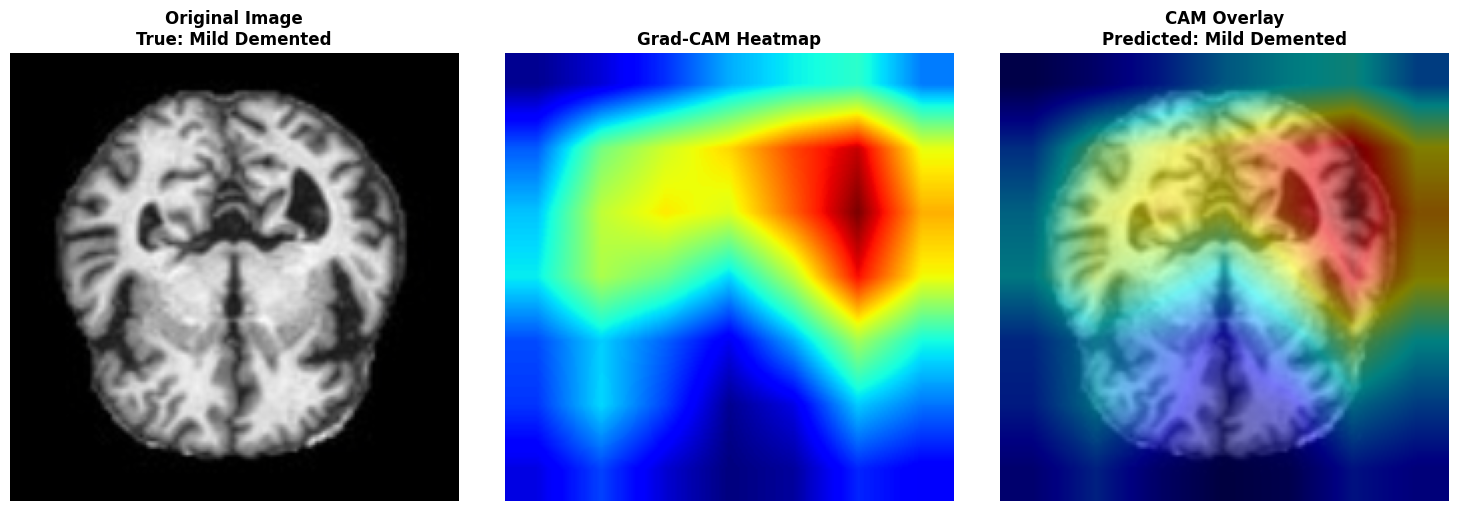


🔍 Class: Moderate Demented


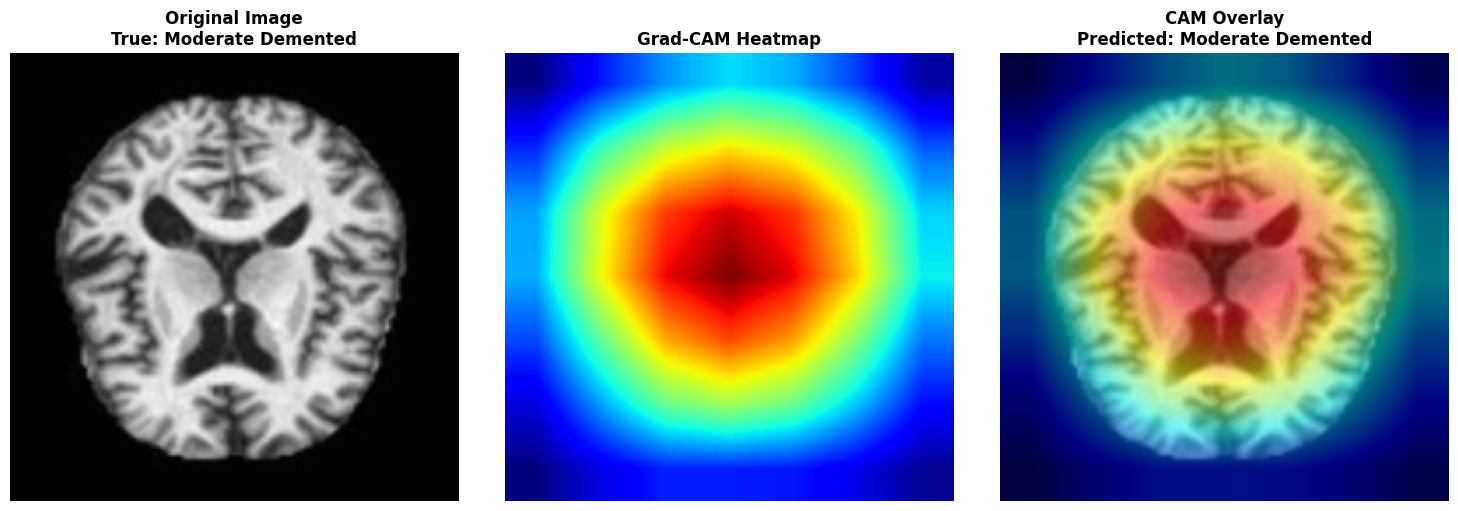


🔍 Class: Non Demented


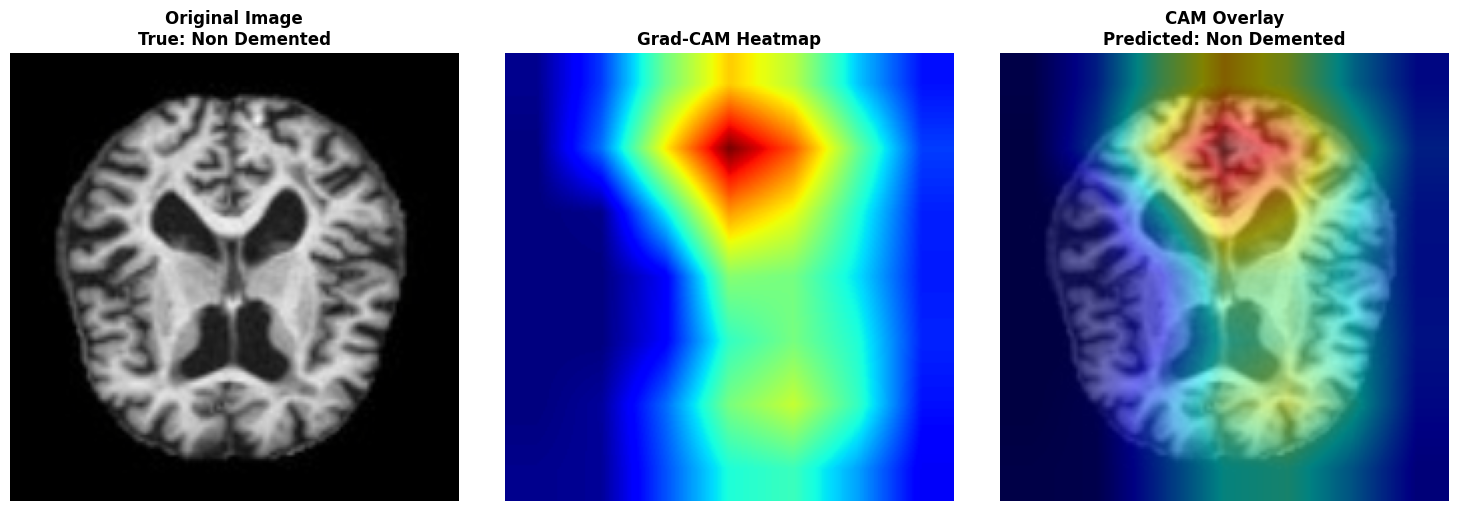


🔍 Class: Very Mild Demented


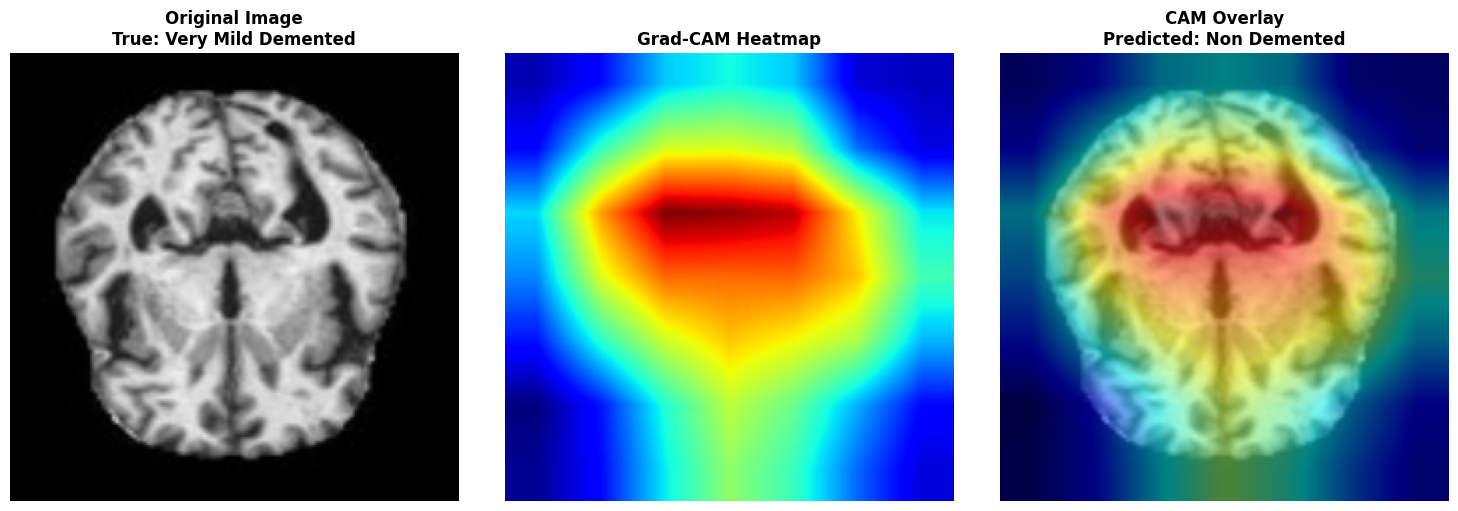


✅ Grad-CAM visualizations complete!


In [28]:
# ============================================
# GENERATE GRAD-CAM VISUALIZATIONS
# ============================================

print("🔥 Generating Grad-CAM visualizations...")
print("="*70)

# Get the target layer (last convolutional layer of ResNet18)
target_layer = trained_model.layer4[-1]

# Create Grad-CAM visualizer
grad_cam_viz = GradCAMVisualizer(trained_model, target_layer)

# Visualize examples from each class
trained_model.eval()

print("\n📸 Generating Grad-CAM for sample predictions...\n")

for class_idx in range(NUM_CLASSES):
    print(f"🔍 Class: {CLASS_NAMES[class_idx]}")

    # Find a correctly classified example from this class
    class_samples = [i for i, (_, label) in enumerate(val_dataset) if label == class_idx]

    if len(class_samples) == 0:
        print(f"   ⚠️ No validation samples found for {CLASS_NAMES[class_idx]}")
        continue

    # Get first sample
    sample_idx = class_samples[0]
    img, label = val_dataset[sample_idx]

    # Get prediction
    img_tensor = img.to(device)
    with torch.no_grad():
        output = trained_model(img_tensor.unsqueeze(0))
        _, pred = torch.max(output, 1)

    # Visualize
    grad_cam_viz.visualize(img_tensor, label, pred.item(), CLASS_NAMES)
    print()

print("="*70)
print("✅ Grad-CAM visualizations complete!")

In [29]:
# ============================================
# SAVE TRAINED MODEL
# ============================================

print("💾 Saving trained model...")

# Save complete checkpoint
checkpoint = {
    'epoch': len(history['train_loss']),
    'model_state_dict': trained_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_acc': history['train_acc'][-1],
    'val_acc': history['val_acc'][-1],
    'train_loss': history['train_loss'][-1],
    'val_loss': history['val_loss'][-1],
    'class_names': CLASS_NAMES,
    'config': CONFIG,
    'history': history
}

torch.save(checkpoint, 'alzheimers_mri_checkpoint.pth')
print("✅ Full checkpoint saved: alzheimers_mri_checkpoint.pth")

# Save model weights only (for easier loading)
torch.save(trained_model.state_dict(), 'alzheimers_mri_weights.pth')
print("✅ Model weights saved: alzheimers_mri_weights.pth")

print("\n📦 Model files ready for submission!")

💾 Saving trained model...
✅ Full checkpoint saved: alzheimers_mri_checkpoint.pth
✅ Model weights saved: alzheimers_mri_weights.pth

📦 Model files ready for submission!


In [30]:
# ============================================
# MODEL LOADING FUNCTION
# ============================================

def load_trained_model(weights_path, num_classes=4):
    """
    Load a trained model from saved weights

    Args:
        weights_path: Path to saved model weights
        num_classes: Number of output classes

    Returns:
        model: Loaded model ready for inference
    """
    # Create model architecture
    model = models.resnet18(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    # Load weights
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()

    print(f"✅ Model loaded from {weights_path}")
    return model

# Example usage (commented out):
# loaded_model = load_trained_model('alzheimers_mri_weights.pth')

print("✅ Model loading function defined!")

✅ Model loading function defined!


In [31]:
# ============================================
# PROJECT SUMMARY
# ============================================

print("\n" + "="*70)
print("🎉 PROJECT COMPLETE!")
print("="*70)

print("\n📊 Final Results Summary:")
print(f"   Best Validation Accuracy: {max(history['val_acc'])*100:.2f}%")
print(f"   Total Epochs Trained: {len(history['train_loss'])}")
print(f"   Final Learning Rate: {history['lr'][-1]:.6f}")

print("\n📁 Saved Files:")
print("   ✅ alzheimers_mri_checkpoint.pth (full checkpoint)")
print("   ✅ alzheimers_mri_weights.pth (model weights only)")

print("\n📋 Hackathon Checklist:")
checklist = {
    "Reproducibility (seeds set)": "✅",
    "Exploratory Data Analysis": "✅",
    "Train/Validation Split": "✅",
    "Baseline Model (ResNet18)": "✅",
    "Data Augmentation": "✅",
    "Model Training": "✅",
    "Training History Plots": "✅",
    "Confusion Matrix": "✅",
    "Per-Class Metrics": "✅",
    "Error Analysis": "✅",
    "Grad-CAM Explainability": "✅",
    "Model Saved": "✅",
    "Code Documentation": "✅"
}

for item, status in checklist.items():
    print(f"   {status} {item}")

print("\n🎯 Next Steps for Submission:")
print("   1. Review and clean this notebook")
print("   2. Prepare 5-7 minute presentation")
print("   3. Write project abstract")
print("   4. Test notebook end-to-end (Runtime → Restart and run all)")
print("   5. Submit to hackathon portal")

print("\n💡 Potential Improvements to Consider:")
print("   • Try different architectures (ResNet50, EfficientNet)")
print("   • Implement k-fold cross-validation")
print("   • Hyperparameter tuning with Optuna")
print("   • Ensemble multiple models")
print("   • Add test-time augmentation (TTA)")

print("\n" + "="*70)
print("Good luck with your submission! 🚀")
print("="*70)


🎉 PROJECT COMPLETE!

📊 Final Results Summary:
   Best Validation Accuracy: 93.07%
   Total Epochs Trained: 15
   Final Learning Rate: 0.000100

📁 Saved Files:
   ✅ alzheimers_mri_checkpoint.pth (full checkpoint)
   ✅ alzheimers_mri_weights.pth (model weights only)

📋 Hackathon Checklist:
   ✅ Reproducibility (seeds set)
   ✅ Exploratory Data Analysis
   ✅ Train/Validation Split
   ✅ Baseline Model (ResNet18)
   ✅ Data Augmentation
   ✅ Model Training
   ✅ Training History Plots
   ✅ Confusion Matrix
   ✅ Per-Class Metrics
   ✅ Error Analysis
   ✅ Grad-CAM Explainability
   ✅ Model Saved
   ✅ Code Documentation

🎯 Next Steps for Submission:
   1. Review and clean this notebook
   2. Prepare 5-7 minute presentation
   3. Write project abstract
   4. Test notebook end-to-end (Runtime → Restart and run all)
   5. Submit to hackathon portal

💡 Potential Improvements to Consider:
   • Try different architectures (ResNet50, EfficientNet)
   • Implement k-fold cross-validation
   • Hyperparam

In [32]:
# ============================================
# DOWNLOAD MODEL FILES
# ============================================

from google.colab import files

print("📥 Downloading model files...")

# Download checkpoint
files.download('alzheimers_mri_checkpoint.pth')
print("✅ Downloaded: alzheimers_mri_checkpoint.pth")

# Download weights
files.download('alzheimers_mri_weights.pth')
print("✅ Downloaded: alzheimers_mri_weights.pth")

print("\n✅ All files downloaded!")

📥 Downloading model files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: alzheimers_mri_checkpoint.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: alzheimers_mri_weights.pth

✅ All files downloaded!
